To run this notebook you'll need to install `whatlies`. 

```
python -m pip install whatlies
```

# Part One 

This part of the notebook will try to visualise the bias that exists in word embeddings. 

In [4]:
from whatlies import Embedding, EmbeddingSet
from whatlies.transformers import Pca
from whatlies.language import FasttextLanguage, SpacyLanguage, BytePairLang

In [5]:
lang_ft = FasttextLanguage("cc.en.300.bin")
lang_sp = SpacyLanguage("en_core_web_sm")

/Users/vincent/Development/whatlies/venv/lib/python3.7/site-packages/spacy/util.py:271: UserWarning: [W031] Model 'en_core_web_sm' (2.2.5) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.0). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [39]:
e1 = lang_ft["man"] - lang_ft["woman"]
e2 = lang_ft["he"] - lang_ft["she"]
e1.distance(e2)

0.4683841

In [40]:
stereotype_pairs = [
    ('sewing', 'carpentry'),
    ('nurse', 'physician'),
    ('nurse', 'surgeon'),
    ('nurse', 'doctor'),
    ('diva', 'rockstar'),
]

appropriate_pairs = [
    ('woman', 'man'),
    ('queen', 'king'),
    ('sister', 'brother'),
    ('mother', 'father'),
    ('ovarian', 'prostate'),
    ('she', 'he'),
    ('her', 'him'),
    ('girl', 'boy')
]

random_pairs = [
    ('dog', 'firehydrant'),
    ('cat', 'record'),
    ('carpet', 'leg'), 
    ('hot', 'cold'),
    ('coffee', 'milk'),
    ('fire', 'ice'),
    ('rich', 'poor'),
    ('more', 'less'),
    ('math', 'language')
]

In [41]:
flatten = lambda l: [item for sublist in l for item in sublist]

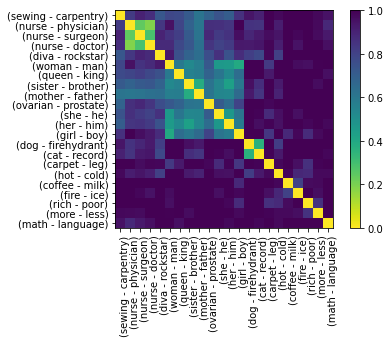

In [42]:
def calc_axis(pair_list, language_model):
    return [language_model[t1] - language_model[t2] for (t1, t2) in pair_list]

def make_correlation_plot(pairs, language_model, metric="cosine"):
    emb_pairs = EmbeddingSet(*flatten([calc_axis(p, language_model) for p in pairs]))
    emb_pairs.plot_distance(metric=metric)

make_correlation_plot(pairs=[stereotype_pairs, appropriate_pairs, random_pairs], language_model=lang_ft)

/Users/vincent/Development/whatlies/venv/lib/python3.7/site-packages/spacy/util.py:271: UserWarning: [W031] Model 'en_core_web_sm' (2.2.5) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.0). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


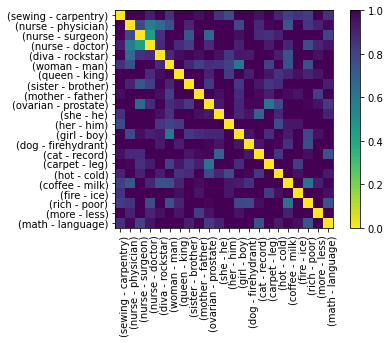

In [43]:
make_correlation_plot(pairs=[stereotype_pairs, appropriate_pairs, random_pairs], language_model=SpacyLanguage("en_core_web_sm"))

/Users/vincent/Development/whatlies/venv/lib/python3.7/site-packages/spacy/util.py:271: UserWarning: [W031] Model 'en_core_web_md' (2.2.5) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.0). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


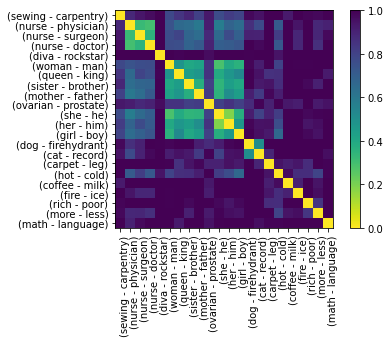

In [44]:
make_correlation_plot(pairs=[stereotype_pairs, appropriate_pairs, random_pairs], language_model=SpacyLanguage("en_core_web_md"))

/Users/vincent/Development/whatlies/venv/lib/python3.7/site-packages/spacy/util.py:271: UserWarning: [W031] Model 'en_core_web_lg' (2.2.5) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.0). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


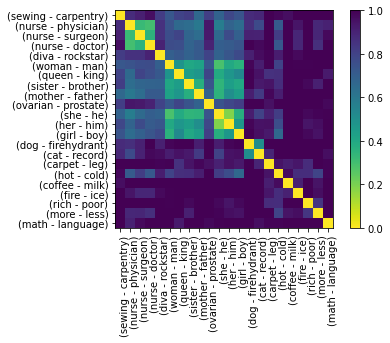

In [45]:
make_correlation_plot(pairs=[stereotype_pairs, appropriate_pairs, random_pairs], language_model=SpacyLanguage("en_core_web_lg"))

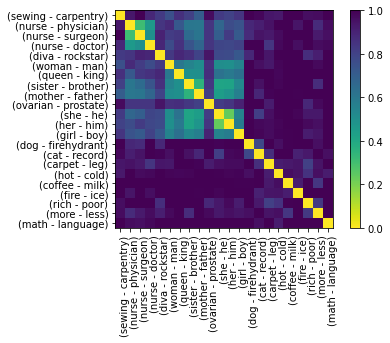

In [46]:
make_correlation_plot(pairs=[stereotype_pairs, appropriate_pairs, random_pairs], language_model=BytePairLang("en", dim=300, vs=200_000))

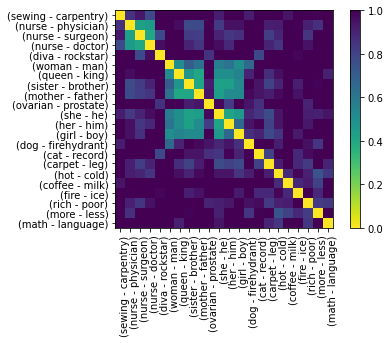

In [47]:
make_correlation_plot(pairs=[stereotype_pairs, appropriate_pairs, random_pairs], language_model=BytePairLang("en", dim=100, vs=10000))

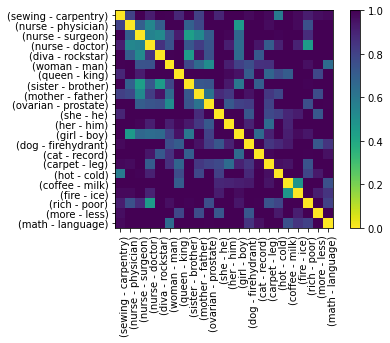

In [48]:
make_correlation_plot(pairs=[stereotype_pairs, appropriate_pairs, random_pairs], language_model=BytePairLang("en", dim=25, vs=1000))

You can see that there's is a correlation between a professional axis as well as a gender axis. There are embeddings where this is less of an affect but these are unfortunately also the embeddings where there is less information stored. This is highly unfortunate because it suggests that our language model might be amplifying bias. 

## Part 2: Debiasing 

In this part of notebook demonstrates an attempt at debiasing the word-embeddings.

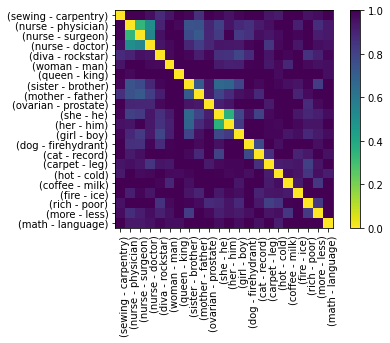

In [49]:
def calc_axis(pair_list, language_model):
    return [language_model[t1] - language_model[t2] for (t1, t2) in pair_list]

def make_debias_correlation_plot(pairs, language_model, metric='cosine'):
    emb_pairs = EmbeddingSet(*flatten([calc_axis(p, language_model) for p in pairs]))
    norm_emb = EmbeddingSet(
        (language_model['man'] - language_model['woman']),
        (language_model['king'] - language_model['queen']),
        (language_model['father'] - language_model['mother'])
    ).average()
    emb_pairs = emb_pairs | norm_emb
    emb_pairs.plot_distance(metric=metric)
    return emb_pairs
    
_ = make_debias_correlation_plot(pairs=[stereotype_pairs, appropriate_pairs, random_pairs], 
                                 language_model=BytePairLang("en", dim=300, vs=200_000))

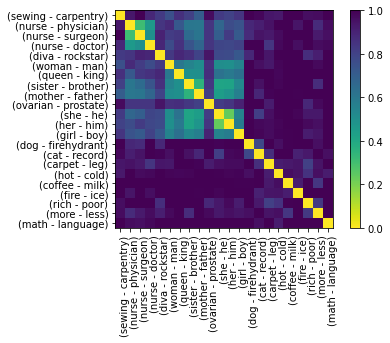

In [50]:
make_correlation_plot(pairs=[stereotype_pairs, appropriate_pairs, random_pairs], language_model=BytePairLang("en", dim=300, vs=200_000))

There seems to be less bias now. You could say this is a good thing. Unfortunately though, it is not enough. 

## Part 3: Lipstick on a Pig

This part is **heavily** inspired by the [lipstick on a pig paper](https://arxiv.org/pdf/1903.03862.pdf). We'll be trying to reproduce parts of the paper.

In [51]:
female_words = ["countrywoman","receptionist","sororal","witches","maidservant","mothers","diva","actress","spinster","mama","duchesses","barwoman","countrywomen","dowry","hostesses","airwomen","menopause","clitoris","princess","governesses","abbess","women","widow","ladies","sorceresses","madam","brides","baroness","housewives","godesses","niece","widows","lady","sister","brides","nun","adultresses","obstetrics","bellgirls","her","marchioness","princesses","empresses","mare","chairwoman","convent","priestesses","girlhood","ladies","queen","gals","mommies","maid","female_ejaculation","spokeswoman","seamstress","cowgirls","chick","spinsters","hair_salon","empress","mommy","feminism","gals","enchantress","gal","motherhood","estrogen","camerawomen","godmother","strongwoman","goddess","matriarch","aunt","chairwomen","ma'am","sisterhood","hostess","estradiol","wife","mom","stewardess","females","viagra","spokeswomen","ma","belle","minx","maiden","witch","miss","nieces","mothered","cow","belles","councilwomen","landladies","granddaughter","fiancees","stepmothers","horsewomen","grandmothers","adultress","schoolgirl","hen","granddaughters","bachelorette","camerawoman","moms","her","mistress","lass","policewoman","nun","actresses","saleswomen","girlfriend","councilwoman","lady","stateswoman","maternal","lass","landlady","sistren","ladies","wenches","sorority","bellgirl","duchess","ballerina","chicks","fiancee","fillies","wives","suitress","maternity","she","businesswoman","masseuses","heroine","doe","busgirls","girlfriends","queens","sisters","mistresses","stepmother","brides","daughter","minxes","cowgirl","lady","daughters","mezzo","saleswoman","mistress","hostess","nuns","maids","mrs.","headmistresses","lasses","congresswoman","airwoman","housewife","priestess","barwomen","barnoesses","abbesses","handywoman","toque","sororities","stewardesses","filly","czarina","stepdaughters","herself","girls","lionesses","lady","vagina","hers","masseuse","cows","aunts","wench","toques","wife","lioness","sorceress","effeminate","mother","lesbians","female","waitresses","ovum","skene_gland","stepdaughter","womb","businesswomen","heiress","waitress","headmistress","woman","governess","godess","bride","grandma","bride","gal","lesbian","ladies","girl","grandmother","mare","maternity","hens","uterus","nuns","maidservants","seamstress'","busgirl","heroines",]
male_words = ["countryman","fraternal","wizards","manservant","fathers","divo","actor","bachelor","papa","dukes","barman","countrymen","brideprice","hosts","airmen","andropause","penis","prince","governors","abbot","men","widower","gentlemen","sorcerers","sir","bridegrooms","baron","househusbands","gods","nephew","widowers","lord","brother","grooms","priest","adultors","andrology","bellboys","his","marquis","princes","emperors","stallion","chairman","monastery","priests","boyhood","fellas","king","dudes","daddies","manservant","semen","spokesman","tailor","cowboys","dude","bachelors","barbershop","emperor","daddy","masculism","guys","enchanter","guy","fatherhood","androgen","cameramen","godfather","strongman","god","patriarch","uncle","chairmen","sir","brotherhood","host","testosterone","husband","dad","steward","males","cialis","spokesmen","pa","beau","stud","bachelor","wizard","sir","nephews","fathered","bull","beaus","councilmen","landlords","grandson","fiances","stepfathers","horsemen","grandfathers","adultor","schoolboy","rooster","grandsons","bachelor","cameraman","dads","him","master","lad","policeman","monk","actors","salesmen","boyfriend","councilman","fella","statesman","paternal","chap","landlord","brethren","lords","blokes","fraternity","bellboy","duke","ballet_dancer","dudes","fiance","colts","husbands","suitor","paternity","he","businessman","masseurs","hero","deer","busboys","boyfriends","kings","brothers","masters","stepfather","grooms","son","studs","cowboy","mentleman","sons","baritone","salesman","paramour","male_host","monks","menservants","mr.","headmasters","lads","congressman","airman","househusband","priest","barmen","barons","abbots","handyman","beard","fraternities","stewards","colt","czar","stepsons","himself","boys","lions","gentleman","penis","his","masseur","bulls","uncles","bloke","beards","hubby","lion","sorcerer","macho","father","gays","male","waiters","sperm","prostate","stepson","prostatic_utricle","businessmen","heir","waiter","headmaster","man","governor","god","bridegroom","grandpa","groom","dude","gay","gents","boy","grandfather","gelding","paternity","roosters","prostatic_utricle","priests","manservants","stailor","busboy","heros"]

In [52]:
stereotype_pairs = [
    ('sewing', 'carpentry'),
    ('nurse', 'physician'),
    ('nurse', 'surgeon'),
    ('nurse', 'doctor'),
    ('diva', 'rockstar'),
    ('doctor', 'nurse'),
]

appropriate_pairs = [
    ('woman', 'man'),
    ('queen', 'king'),
    ('sister', 'brother'),
    ('mother', 'father'),
    ('ovarian', 'prostate'),
    ('he', 'she'),
    ('him', 'her'),
    ('boy', 'girl')
]

random_pairs = [
    ('dog', 'firehydrant'),
    ('cat', 'record'),
    ('carpet', 'leg'), 
    ('hot', 'cold'),
    ('coffee', 'milk'),
    ('fire', 'ice'),
    ('rich', 'poor'),
    ('more', 'less'),
    ('math', 'language')
]

In [53]:
words = ["a","ability","able","about","above","accept","according","account","across","act","action","activity","actually","add","address","administration","admit","adult","affect","after","again","against","age","agency","agent","ago","agree","agreement","ahead","air","all","allow","almost","alone","along","already","also","although","always","American","among","amount","analysis","and","animal","another","answer","any","anyone","anything","appear","apply","approach","area","argue","arm","around","arrive","art","article","artist","as","ask","assume","at","attack","attention","attorney","audience","author","authority","available","avoid","away","baby","back","bad","bag","ball","bank","bar","base","be","beat","beautiful","because","become","bed","before","begin","behavior","behind","believe","benefit","best","better","between","beyond","big","bill","billion","bit","black","blood","blue","board","body","book","born","both","box","boy","break","bring","brother","budget","build","building","business","but","buy","by","call","camera","campaign","can","cancer","candidate","capital","car","card","care","career","carry","case","catch","cause","cell","center","central","century","certain","certainly","chair","challenge","chance","change","character","charge","check","child","choice","choose","church","citizen","city","civil","claim","class","clear","clearly","close","coach","cold","collection","college","color","come","commercial","common","community","company","compare","computer","concern","condition","conference","Congress","consider","consumer","contain","continue","control","cost","could","country","couple","course","court","cover","create","crime","cultural","culture","cup","current","customer","cut","dark","data","daughter","day","dead","deal","death","debate","decade","decide","decision","deep","defense","degree","Democrat","democratic","describe","design","despite","detail","determine","develop","development","die","difference","different","difficult","dinner","direction","director","discover","discuss","discussion","disease","do","doctor","dog","door","down","draw","dream","drive","drop","drug","during","each","early","east","easy","eat","economic","economy","edge","education","effect","effort","eight","either","election","else","employee","end","energy","enjoy","enough","enter","entire","environment","environmental","especially","establish","even","evening","event","ever","every","everybody","everyone","everything","evidence","exactly","example","executive","exist","expect","experience","expert","explain","eye","face","fact","factor","fail","fall","family","far","fast","father","fear","federal","feel","feeling","few","field","fight","figure","fill","film","final","finally","financial","find","fine","finger","finish","fire","firm","first","fish","five","floor","fly","focus","follow","food","foot","for","force","foreign","forget","form","former","forward","four","free","friend","from","front","full","fund","future","game","garden","gas","general","generation","get","girl","give","glass","go","goal","good","government","great","green","ground","group","grow","growth","guess","gun","guy","hair","half","hand","hang","happen","happy","hard","have","he","head","health","hear","heart","heat","heavy","help","her","here","herself","high","him","himself","his","history","hit","hold","home","hope","hospital","hot","hotel","hour","house","how","however","huge","human","hundred","husband","I","idea","identify","if","image","imagine","impact","important","improve","in","include","including","increase","indeed","indicate","individual","industry","information","inside","instead","institution","interest","interesting","international","interview","into","investment","involve","issue","it","item","its","itself","job","join","just","keep","key","kid","kill","kind","kitchen","know","knowledge","land","language","large","last","late","later","laugh","law","lawyer","lay","lead","leader","learn","least","leave","left","leg","legal","less","let","letter","level","lie","life","light","like","likely","line","list","listen","little","live","local","long","look","lose","loss","lot","love","low","machine","magazine","main","maintain","major","majority","make","man","manage","management","manager","many","market","marriage","material","matter","may","maybe","me","mean","measure","media","medical","meet","meeting","member","memory","mention","message","method","middle","might","military","million","mind","minute","miss","mission","model","modern","moment","money","month","more","morning","most","mother","mouth","move","movement","movie","Mr","Mrs","much","music","must","my","myself","name","nation","national","natural","nature","near","nearly","necessary","need","network","never","new","news","newspaper","next","nice","night","no","none","nor","north","not","note","nothing","notice","now","number","occur","of","off","offer","office","officer","official","often","oh","oil","ok","old","on","once","one","only","onto","open","operation","opportunity","option","or","order","organization","other","others","our","out","outside","over","own","owner","page","pain","painting","paper","parent","part","participant","particular","particularly","partner","party","pass","past","patient","pattern","pay","peace","people","per","perform","performance","perhaps","period","person","personal","phone","physical","pick","picture","piece","place","plan","plant","play","player","PM","point","police","policy","political","politics","poor","popular","population","position","positive","possible","power","practice","prepare","present","president","pressure","pretty","prevent","price","private","probably","problem","process","produce","product","production","professional","professor","program","project","property","protect","prove","provide","public","pull","purpose","push","put","quality","question","quickly","quite","race","radio","raise","range","rate","rather","reach","read","ready","real","reality","realize","really","reason","receive","recent","recently","recognize","record","red","reduce","reflect","region","relate","relationship","religious","remain","remember","remove","report","represent","Republican","require","research","resource","respond","response","responsibility","rest","result","return","reveal","rich","right","rise","risk","road","rock","role","room","rule","run","safe","same","save","say","scene","school","science","scientist","score","sea","season","seat","second","section","security","see","seek","seem","sell","send","senior","sense","series","serious","serve","service","set","seven","several","sex","sexual","shake","share","she","shoot","short","shot","should","shoulder","show","side","sign","significant","similar","simple","simply","since","sing","single","sister","sit","site","situation","six","size","skill","skin","small","smile","so","social","society","soldier","some","somebody","someone","something","sometimes","son","song","soon","sort","sound","source","south","southern","space","speak","special","specific","speech","spend","sport","spring","staff","stage","stand","standard","star","start","state","statement","station","stay","step","still","stock","stop","store","story","strategy","street","strong","structure","student","study","stuff","style","subject","success","successful","such","suddenly","suffer","suggest","summer","support","sure","surface","system","table","take","talk","task","tax","teach","teacher","team","technology","television","tell","ten","tend","term","test","than","thank","that","the","their","them","themselves","then","theory","there","these","they","thing","think","third","this","those","though","thought","thousand","threat","three","through","throughout","throw","thus","time","to","today","together","tonight","too","top","total","tough","toward","town","trade","traditional","training","travel","treat","treatment","tree","trial","trip","trouble","true","truth","try","turn","TV","two","type","under","understand","unit","until","up","upon","us","use","usually","value","various","very","victim","view","violence","visit","voice","vote","wait","walk","wall","want","war","watch","water","way","we","weapon","wear","week","weight","well","west","western","what","whatever","when","where","whether","which","while","white","who","whole","whom","whose","why","wide","wife","will","win","wind","window","wish","with","within","without","woman","wonder","word","work","worker","world","worry","would","write","writer","wrong","yard","yeah","year","yes","yet","you","young","your","yourself",]
professions = ["accountant","acquaintance","actor","actress","adjunct_professor","administrator","adventurer","advocate","aide","alderman","alter_ego","ambassador","analyst","anthropologist","archaeologist","archbishop","architect","artist","artiste","assassin","assistant_professor","associate_dean","associate_professor","astronaut","astronomer","athlete","athletic_director","attorney","author","baker","ballerina","ballplayer","banker","barber","baron","barrister","bartender","biologist","bishop","bodyguard","bookkeeper","boss","boxer","broadcaster","broker","bureaucrat","businessman","businesswoman","butcher","butler","cab_driver","cabbie","cameraman","campaigner","captain","cardiologist","caretaker","carpenter","cartoonist","cellist","chancellor","chaplain","character","chef","chemist","choreographer","cinematographer","citizen","civil_servant","cleric","clerk","coach","collector","colonel","columnist","comedian","comic","commander","commentator","commissioner","composer","conductor","confesses","congressman","constable","consultant","cop","correspondent","councilman","councilor","counselor","critic","crooner","crusader","curator","custodian","dad","dancer","dean","dentist","deputy","dermatologist","detective","diplomat","director","disc_jockey","doctor","doctoral_student","drug_addict","drummer","economics_professor","economist","editor","educator","electrician","employee","entertainer","entrepreneur","environmentalist","envoy","epidemiologist","evangelist","farmer","fashion_designer","fighter_pilot","filmmaker","financier","firebrand","firefighter","fireman","fisherman","footballer","foreman","freelance_writer","gangster","gardener","geologist","goalkeeper","graphic_designer","guidance_counselor","guitarist","hairdresser","handyman","headmaster","historian","hitman","homemaker","hooker","housekeeper","housewife","illustrator","industrialist","infielder","inspector","instructor","interior_designer","inventor","investigator","investment_banker","janitor","jeweler","journalist","judge","jurist","laborer","landlord","lawmaker","lawyer","lecturer","legislator","librarian","lieutenant","lifeguard","lyricist","maestro","magician","magistrate","maid","major_leaguer","manager","marksman","marshal","mathematician","mechanic","mediator","medic","midfielder","minister","missionary","mobster","monk","musician","nanny","narrator","naturalist","negotiator","neurologist","neurosurgeon","novelist","nun","nurse","observer","officer","organist","painter","paralegal","parishioner","parliamentarian","pastor","pathologist","patrolman","pediatrician","performer","pharmacist","philanthropist","philosopher","photographer","photojournalist","physician","physicist","pianist","planner","plastic_surgeon","playwright","plumber","poet","policeman","politician","pollster","preacher","president","priest","principal","prisoner","professor","professor_emeritus","programmer","promoter","proprietor","prosecutor","protagonist","protege","protester","provost","psychiatrist","psychologist","publicist","pundit","rabbi","radiologist","ranger","realtor","receptionist","registered_nurse","researcher","restaurateur","sailor","saint","salesman","saxophonist","scholar","scientist","screenwriter","sculptor","secretary","senator","sergeant","servant","serviceman","sheriff_deputy","shopkeeper","singer","singer_songwriter","skipper","socialite","sociologist","soft_spoken","soldier","solicitor","solicitor_general","soloist","sportsman","sportswriter","statesman","steward","stockbroker","strategist","student","stylist","substitute","superintendent","surgeon","surveyor","swimmer","taxi_driver","teacher","technician","teenager","therapist","trader","treasurer","trooper","trucker","trumpeter","tutor","tycoon","undersecretary","understudy","valedictorian","vice_chancellor","violinist","vocalist","waiter","waitress","warden","warrior","welder","worker","wrestler","writer"]
gendered_words = ["he", "his", "He", "her", "she", "him", "She", "man", "women", "men", "His", "woman", "spokesman", "wife", "himself", "son", "mother", "father", "chairman", "daughter", "husband", "guy", "girls", "girl", "Her", "boy", "King", "boys", "brother", "Chairman", "spokeswoman", "female", "sister", "Women", "Man", "male", "herself", "Lions", "Lady", "brothers", "dad", "actress", "mom", "sons", "girlfriend", "Kings", "Men", "daughters", "Prince", "Queen", "teenager", "lady", "Bulls", "boyfriend", "sisters", "Colts", "mothers", "Sir", "king", "businessman", "Boys", "grandmother", "grandfather", "deer", "cousin", "Woman", "ladies", "Girls", "Father", "uncle", "PA", "Boy", "Councilman", "mum", "Brothers", "MA", "males", "Girl", "Mom", "Guy", "Queens", "congressman", "Dad", "Mother", "grandson", "twins", "bull", "queen", "businessmen", "wives", "widow", "nephew", "bride", "females", "aunt", "Congressman", "prostate_cancer", "lesbian", "chairwoman", "fathers", "Son", "moms", "Ladies", "maiden", "granddaughter", "younger_brother", "Princess", "Guys", "lads", "Ma", "Sons", "lion", "Bachelor", "gentleman", "fraternity", "bachelor", "niece", "Lion", "Sister", "bulls", "husbands", "prince", "colt", "salesman", "Bull", "Sisters", "hers", "dude", "Spokesman", "beard", "filly", "Actress", "Him", "princess", "Brother", "lesbians", "councilman", "actresses", "Viagra", "gentlemen", "stepfather", "Deer", "monks", "Beard", "Uncle", "ex_girlfriend", "lad", "sperm", "Daddy", "testosterone", "MAN", "Female", "nephews", "maid", "daddy", "mare", "fiance", "Wife", "fiancee", "kings", "dads", "waitress", "Male", "maternal", "heroine", "feminist", "Mama", "nieces", "girlfriends", "Councilwoman", "sir", "stud", "Mothers", "mistress", "lions", "estranged_wife", "womb", "Brotherhood", "Statesman", "grandma", "maternity", "estrogen", "ex_boyfriend", "widows", "gelding", "diva", "teenage_girls", "nuns", "Daughter", "czar", "ovarian_cancer", "HE", "Monk", "countrymen", "Grandma", "teenage_girl", "penis", "bloke", "nun", "Husband", "brides", "housewife", "spokesmen", "suitors", "menopause", "monastery", "patriarch", "Beau", "motherhood", "brethren", "stepmother", "Dude", "prostate", "Moms", "hostess", "twin_brother", "Colt", "schoolboy", "eldest", "brotherhood", "Godfather", "fillies", "stepson", "congresswoman", "Chairwoman", "Daughters", "uncles", "witch", "Mommy", "monk", "viagra", "paternity", "suitor", "chick", "Pa", "fianc\u00e9", "sorority", "macho", "Spokeswoman", "businesswoman", "eldest_son", "gal", "statesman", "schoolgirl", "fathered", "goddess", "hubby", "mares", "stepdaughter", "blokes", "dudes", "socialite", "strongman", "Witch", "fianc\u00e9e", "uterus", "grandsons", "Bride", "studs", "mama", "Aunt", "godfather", "hens", "hen", "mommy", "Babe", "estranged_husband", "Fathers", "elder_brother", "boyhood", "baritone", "Diva", "Lesbian", "grandmothers", "grandpa", "boyfriends", "feminism", "countryman", "stallion", "heiress", "queens", "Grandpa", "witches", "aunts", "semen", "fella", "granddaughters", "chap", "knight", "widower", "Maiden", "salesmen", "convent", "KING", "vagina", "beau", "babe", "HIS", "beards", "handyman", "twin_sister", "maids", "gals", "housewives", "Gentlemen", "horsemen", "Businessman", "obstetrics", "fatherhood", "beauty_queen", "councilwoman", "princes", "matriarch", "colts", "manly", "ma", "fraternities", "Spokesmen", "pa", "fellas", "Gentleman", "councilmen", "dowry", "barbershop", "Monks", "WOMAN", "fraternal", "ballerina", "manhood", "Dads", "heroines", "granny", "gynecologist", "princesses", "Goddess", "yo", "Granny", "knights", "eldest_daughter", "HER", "underage_girls", "masculinity", "Girlfriend", "bro", "Grandmother", "grandfathers", "crown_prince", "Restless", "paternal", "Queen_Mother", "Boyfriend", "womens", "Males", "SHE", "Countess", "stepchildren", "Belles", "bachelors", "matron", "momma", "Legs", "maidens", "goddesses", "landlady", "sisterhood", "Grandfather", "Fraternity", "Majesty", "Babes", "lass", "maternal_grandmother", "blondes", "ma'am", "Womens", "divorcee", "Momma", "fathering", "Effie", "Lad", "womanhood", "missus", "Sisterhood", "granddad", "Mens", "papa", "gf", "sis", "Husbands", "Hen", "womanizer", "gynecological", "stepsister", "Handsome", "Prince_Charming", "BOY", "stepdad", "teen_ager", "GIRL", "dame", "Sorority", "beauty_pageants", "raspy", "harem", "maternal_grandfather", "Hes", "deliveryman", "septuagenarian", "damsel", "paternal_grandmother", "paramour", "paternal_grandparents", "Nun", "DAD", "mothering", "shes", "HE_'S", "Nuns", "teenage_daughters", "auntie", "widowed_mother", "Girlfriends", "FATHER", "virile", "COUPLE", "grandmas", "Hubby", "nan", "vixen", "Joan_Crawford", "stepdaughters", "endometrial_cancer", "stepsons", "loins", "Grandson", "Mitchells", "erections", "Matron", "Fella", "daddies", "ter", "Sweetie", "Dudes", "Princesses", "Lads", "lioness", "Mamma", "virility", "bros", "womenfolk", "Heir", "BROTHERS", "manliness", "patriarchs", "earl", "sisterly", "Whore", "Gynaecology", "countess", "convents", "Oratory", "witch_doctor", "mamas", "yah", "aunty", "aunties", "Heiress", "lasses", "Breasts", "fairer_sex", "sorority_sisters", "WIFE", "Laurels", "penile", "nuh", "mah", "toms", "mam", "Granddad", "premenopausal_women", "Granddaddy", "nana", "coeds", "dames", "herdsman", "Mammy", "Fellas", "Niece", "menfolk", "Grandad", "bloods", "Gramps", "damsels", "Granddaughter", "mamma", "concubine", "Oros", "Blarney", "filial", "broads", "Ethel_Kennedy", "ACTRESS", "Tit", "fianc", "Hunk", "Night_Shift", "wifey", "Lothario", "Holy_Roman_Emperor", "horse_breeder", "grandnephew", "Lewises", "Muscular", "feminist_movement", "Sanan", "women\u00e2_\u20ac_\u2122", "Fiancee", "dowries", "Carmelite", "rah", "n_roller", "bay_filly", "belles", "Uncles", "PRINCESS", "womans", "Homeboy", "Blokes", "Charmer", "codger", "Delta_Zeta", "courtesans", "grandaughter", "SISTER", "Highness", "grandbabies", "crone", "Skip_Away", "noblewoman", "bf", "jane", "philandering_husband", "Sisqo", "mammy", "daugher", "director_Skip_Bertman", "DAUGHTER", "Royal_Highness", "mannish", "spinsters", "Missus", "madame", "Godfathers", "saleswomen", "beaus", "Risha", "luh", "sah", "negligee", "Women\u00e2_\u20ac_\u2122", "Hos", "salesgirl", "grandmom", "Grandmas", "Lawsons", "countrywomen", "Booby", "darlin", "Sheiks", "boyz", "wifes", "Bayi", "Il_Duce", "\u00e2_\u20ac_\u0153My", "fem", "daugther", "Potti", "hussy", "tch", "Gelding", "stemmed_roses", "Damson", "puh", "Tylers", "neice", "Mutha", "GRANDMOTHER", "youse", "spurned_lover", "mae", "Britt_Ekland", "clotheshorse", "Carlita_Kilpatrick", "Cambest", "Pretty_Polly", "banshees", "male_chauvinist", "Arliss", "mommas", "maidservant", "Gale_Harold", "Little_Bo_Peep", "Cleavers", "hags", "blowsy", "Queen_Elizabeth_I.", "lassies", "papas", "BABE", "ugly_ducklings", "Jims", "hellion", "Beautician", "coalminer", "relaxin", "El_Mahroug", "Victoria_Secret_Angel", "shepherdess", "Mosco", "Slacks", "nanna", "wifely", "tomboys", "LAH", "hast", "apo", "Kaplans", "milkmaid", "Robin_Munis", "John_Barleycorn", "royal_highness", "Meanie", "NAH", "trollop", "roh", "Jewess", "Sheik_Hamad", "mumsy", "Big_Pussy", "chil_dren", "Aunt_Bea", "basso", "sista", "girlies", "nun_Sister", "chica", "Bubbas", "massa", "Southern_belles", "Nephews", "castrations", "Mister_Ed", "Grandsons", "Calaf", "Malachy_McCourt", "Shamash", "hey_hey", "Harmen", "sonofabitch", "Donovans", "Grannie", "Kalinka", "hisself", "Devean", "goatherd", "hinds", "El_Corredor", "Kens", "notorious_womanizer", "goh", "Mommas", "washerwoman", "Samaira", "Coo_Coo", "Governess", "grandsire", "PRINCE_WILLIAM", "gramma", "him.He", "Coptic_priest", "Corbie", "Kennys", "thathe", "Pa_Pa", "Bristols", "Hotep", "snowy_haired", "El_Prado_Ire", "Girl_hitmaker", "Hurleys", "St._Meinrad", "sexually_perverted", "authoress", "Prudie", "raven_haired_beauty", "Bonos", "domestic_shorthair", "brothas", "nymphet", "Neelma", "Seita", "stud_muffin", "St._Judes", "yenta", "bare_shouldered", "Pinkney_Sr.", "PRINCE_CHARLES", "Bisutti", "sistas", "Blanche_Devereaux", "Momoa", "Quiff", "Scotswoman", "balaclava_clad_men", "Louis_Leakey", "dearie", "vacuum_cleaner_salesman", "grandads", "postulant", "SARAH_JESSICA_PARKER", "AUNT", "Prince_Dauntless", "Dalys", "Darkie", "Czar_Nicholas", "Lion_Hearted", "Boy_recliner", "baby_mamas", "giantess", "Lawd", "GRANNY", "fianc_e", "Bilqis", "WCTU", "famly", "Ellas", "feminazis", "Pentheus", "MAMAS", "Town_Criers", "Saggy", "youngman", "grandam", "divorc\u00e9", "bosomed", "roon", "Simmentals", "eponymous_heroine", "LEYLAND", "REE'", "cain't", "Evelynn", "WAH'", "sistah", "Horners", "Elsie_Poncher", "Coochie", "rat_terriers", "Limousins", "Buchinski", "Schicchi", "Carpitcher", "Khwezi", "HAH'", "Shazza", "Mackeson", "ROH'", "kuya", "novice_nun", "Shei", "Elmasri", "ladykiller", "6yo", "Yenta", "SHEL", "pater", "Souse", "Tahirah", "comedian_Rodney_Dangerfield", "Shottle", "carryin", "Sath", "fa'afafine", "royal_consort", "hus_band", "maternal_uncles", "dressing_provocatively", "dreamgirl", "millionaire_industrialist", "Georgie_Girl", "Must_Be_Obeyed", "joh", "Arabian_stallion", "ahr", "mso_para_margin_0in", "SOO'", "Biddles", "Chincoteague_Volunteer_Fire", "Lisa_Miceli", "gorgeous_brunette", "fianc\u017d", "Moved_fluently", "Afternoon_Deelites", "biker_dude", "Vito_Spatafore", "MICK_JAGGER", "Adesida", "Reineman", "witz", "Djamila", "Glenroe", "daddys", "Romanzi", "gentlewomen", "Dandie_Dinmont_terrier", "Excess_Ire", "By_SYVJ_Staff", "zan", "CONFESSIONS", "Magees", "wimmin", "tash", "Theatrical_Ire", "Prince_Charmings", "chocolate_eclair", "bron", "daughers", "Felly", "fiftyish", "Spritely", "GRANDPA", "distaffer", "Norbertines", "DAH'", "leader_Muammar_Gadaffi", "swains", "Prince_Tomohito", "Honneur", "Soeur", "jouster", "Pharaoh_Amenhotep_III", "QUEEN_ELIZABETH_II", "Ne'er", "Galileo_Ire", "Fools_Crow", "Lannisters", "Devines", "gonzales", "columnist_Ann_Landers", "Moseleys", "hiz", "busch", "roastee", "toyboys", "Sheffields", "grandaunt", "Galvins", "Giongo", "geh", "flame_haired_actress", "Grammarian", "Greg_Evigan", "frontierswoman", "Debele", "rabs", "nymphets", "aai", "BREE", "Shaqs", "ZAY", "pappa", "Housa", "refrigerator_repairman", "artificial_inseminations", "chickie", "Rippa", "teenager_Tracy_Turnblad", "homebred_colt", "Abigaille", "hen_pecked_husband", "businesman", "her.She", "Kaikeyi", "Stittsworth", "self_proclaimed_redneck", "Khella", "NeW", "Evers_Swindell", "Asmerom_Gebreselassie", "Boy_recliners", "Cliff_Claven", "Legge_Bourke", "Costos", "d'_honneur", "sistahs", "Cabble", "sahn", "CROW_AGENCY_Mont", "jezebel", "Harrolds", "ROSARIO_DAWSON", "INXS_frontman_Michael_Hutchence", "Gursikh", "Dadas", "VIAGA", "keen_horsewoman", "Theodoric", "Eldery", "lihn", "Alice_Kramden", "Santarina", "radical_cleric_al_Sadr", "Curleys", "SY'", "Fidaa", "Saptapadi", "Actor_Sean_Astin", "Kellita_Smith", "Doly", "Libertina", "Money_McBags", "Chief_Bearhart", "choirgirl", "chestnut_stallion", "VIGRA", "BY_JIM_McCONNELL", "Sal_Vitale", "Trivia_buffs", "kumaris", "fraternal_lodge", "galpals", "Borino_Quinn", "lina", "LATEST_Rapper", "Bezar", "Manro", "bakla", "Grisetti", "blond_bimbo", "spinster_aunt", "gurls", "hiswife", "paleface", "Charlye", "hippie_chicks", "Khalifas", "Picture_JUSTIN_SANSON", "Hepburns", "yez", "ALDER", "Sanussi", "Lil_Sis", "McLoughlins", "Barbra_Jean", "Lulua", "thatshe", "actress_Shohreh_Aghdashloo", "SIR_ANTHONY_HOPKINS", "Gloddy", "ZAH'", "ORANGE_'S", "Danielle_Bimber", "grandmum", "Kulkis", "Brazington", "Marisa_Lenhard_CFA", "SIR_JOHN", "Clareman", "Aqila", "Heavily_tattooed", "Libbys", "thim", "elocutionist", "submissives", "Inja", "rahm", "Agnes_Gooch", "fake_tits", "nancy_boys", "Swaidan", "SHAH'", "ain'ta_bed", "Shumail_Raj", "Duchesse", "diethylstilbestrol_DES", "colt_foal", "unfaithful_lover", "Maseri", "nevah", "SAHN", "Barths", "Toughkenamon", "GUEST_STARS", "him.But", "Donna_Claspell", "gingham_dresses", "Massage_Parlour", "wae", "Wasacz", "Magistra", "vihl", "Smriti_Iraani", "boyish_haircut", "workingwoman", "borthers", "Capuchin_friars", "Nejma", "yes_sirs", "bivocational_pastor", "Grafters", "HOPWOOD", "Nicknamed_Godzilla", "yos", "Berkenfield", "Missis", "sitcom_Designing_Women", "Kafoa", "trainer_Emma_Lavelle", "sadomasochistic_dungeon", "iht", "desperates", "predessor", "wolf_cub", "indigenous_Peruvians", "Livia_Soprano", "troh", "colt_sired", "BOND_HILL", "ihl", "Drydens", "rahs", "Piserchia", "Sonny_Corinthos", "bankrobber", "Fwank", "feisty_redhead", "booze_guzzling", "COOPERS", "actress_Q'orianka_Kilcher", "Cortezar", "twe", "Jacoub", "Cindy_Iannarelli", "Hell_Raiser", "Fondly_referred", "Bridal_Shoppe", "Noleta", "Christinas", "IAGRA", "LaTanya_Richardson", "Sang_Bender", "Assasins", "sorrel_gelding", "septugenarian", "Hissy", "Muqtada_al_Sadr_mook", "Pfeni", "MADRID_AFX_Banco_Santander", "tuchis", "LeVaughn", "Gadzicki", "transvestite_hooker", "Fame_jockey_Laffit", "nun_Sister_Mary", "SAMSONOV", "Mayflower_Madam", "Shaque", "well.He", "Trainer_Julio_Canani", "sorrel_mare", "minivehicle_joint_venture", "wife_Dwina", "Aasiya_AH'_see", "Baratheon", "Rick_O'Shay", "Mammies", "goatie", "Nell_Gwynne", "charmingly_awkward", "Slamma", "DEHL", "Lorenzo_Borghese", "ALMA_Wis.", "Anne_Scurria", "father_Peruvians_alternately", "JULIE_ANDREWS", "Slim_Pickins", "Victoria_Secret_stunner", "BY'", "Sanam_Devdas", "pronounced_luh", "Pasha_Selim", "\u4e2d\u534e", "rson", "maternal_grandmothers", "IOWA_CITY_Ia", "Madame_de_Tourvel", "JAY'", "Sheika_Mozah_bint_Nasser", "Hotsy_Totsy", "D'_Ginto", "singer_Johnny_Paycheck", "uterine_prolapse_surgery", "SCOTTDALE_Pa.", "AdelaideNow_reports", "Marcus_Schenkenberg", "Clyse", "Obiter_Dicta", "comic_Sam_Kinison", "bitties", "ROCKVILLE_Ind.", "swimsuit_calendars", "Decicio_Smith", "Ma_ma", "Rie_Miyazawa", "celibate_chastity", "gwah", "ZAY'", "HER_Majesty", "Defrere", "Las_Madrinas", "\u7c3f_\u8042_\u7ffb", "Bea_Hamill", "ARCADIA_Calif._Trainer", "Bold_Badgett", "stakes_victress", "Hoppin_Frog", "Narumiya", "Flayfil", "hardman_Vinnie_Jones", "Marilyn_Monroe_lookalike", "Kivanc_Tatlitug", "Persis_Khambatta", "SINKING_SPRING_Pa.", "len_3rd", "DEAR_TRYING", "Farndon_Cheshire", "Krishna_Madiga", "daughter_Princess_Chulabhorn", "Marshall_Rooster_Cogburn", "Kitty_Kiernan", "Yokich", "Jarou", "Serdaris", "ee_ay", "Montifiore", "Chuderewicz", "Samuel_Le_Bihan", "filly_Proud_Spell", "Umm_Hiba", "pronounced_koo", "Sandy_Fonzo", "KOR'", "Fielder_Civil_kisses", "Federalsburg_Maryland", "Nikah_ceremony", "Brinke_Stevens", "Yakama_Tribal_Council", "Capuchin_Father", "wife_Callista_Bisek", "Beau_Dare", "Bedoni", "Arjun_Punj", "JOHNNY_KNOXVILLE", "cap_tain", "Alderwood_Boys", "Chi_Eta_Phi", "ringleader_Charles_Graner", "Savoies", "Lalla_Salma", "Mrs._Potiphar", "fahn", "name_Taylor_Sumers", "Vernita_Green", "Bollywood_baddie", "BENBROOK_Texas", "Assemblyman_Lou_Papan", "virgin_brides", "Cho_Eun", "CATHY_Freeman", "Uncle_Saul", "Lao_Brewery", "Ibo_tribe", "ruf", "rival_Edurne_Pasaban", "Hei_Shangri_La", "Mommy_dearest", "interest_Angola_Sonogal", "Ger_Monsun", "PUSSYCAT_DOLL", "Crown_Jewels_Condoms", "Lord_Marke", "Patootie", "Nora_Bey", "huntin_shootin", "Minister_Raymond_Tshibanda", "La_Nina_la_NEEN", "signature_Whoppers", "estranged_hubby_Kevin_Federline", "UR'", "pill_poppin", "GEHR'", "purebred_Arabians", "husbandly_duties", "VIAGRA_TIMING", "Hereford_heifer", "hushed_monotone_voice", "Pola_Uddin", "Wee_Jimmy_Krankie", "Kwakwanso", "Our_Galvinator", "shoh", "Codependency_Anonymous_Group", "LA'", "Taufa'ahau", "Invincible_Spirit_colt", "SAH'_dur", "MOUNT_CARMEL_Pa.", "watches_attentively", "SNL_spinoffs", "Seth_Nitschke", "Duns_Berwickshire", "defendant_Colleen_LaRose", "Silky_O'Sullivan", "Highcliff_Farm", "REN'", "Comestar", "Satisfied_Frog", "Jai_Maharashtra", "ATTICA_Ind.", "lover_Larry_Birkhead", "Tami_Megal", "chauvinist_pigs", "Phi_sorority", "Micronesian_immigrant", "Lia_Boldt", "Sugar_Tits", "actress_Kathy_Najimy", "zhoo", "Colombo_underboss", "Katsav_accusers", "Bess_Houdini", "rap_mogul_Diddy", "companions_Khin_Khin", "Van_Het", "Mastoi_tribe", "VITALY", "ROLLING_STONES_rocker", "womanizing_cad", "LILY_COLE", "paternal_grandfathers", "Lt._Col._Kurt_Kosmatka", "Kasseem_Jr.", "Ji_Ji", "Wilburforce", "VIAGRA_DOSE", "English_Sheepdogs", "pronounced_Kah", "Htet_Htet_Oo", "Brisk_Breeze", "Eau_du", "BY_MELANIE_EVANS", "Neovasc_Medical", "British_funnyman_RICKY", "4YO_mare", "Hemaida", "MONKTON", "Mrs_Mujuru", "BaGhana_BaGhana", "Shaaban_Abdel_Rahim", "Edward_Jazlowiecki_lawyer", "Ajman_Stud", "manly_pharaoh_even", "Serra_Madeira_Islands", "FRAY'", "panto_dames", "Khin_Myo", "dancer_Karima_El_Mahroug", "CROWN_Princess", "Baseball_HOFer", "Hasta_la_Pasta", "GIRLS_NEXT_DOOR", "Benedict_Groeschel", "Bousamra", "Ruby_Rubacuori_Ruby", "Monde_Bleu", "Un_homme_qui", "Taylor_Sumers", "Rapper_EMINEM", "Joe_Menchetti", "VAY'", "supermodel_NAOMI_CAMPBELL", "Supermodel_GISELE_BUNDCHEN", "Au_Lait", "Radar_Installed", "THOMAS_TOWNSHIP_Mich.", "Rafinesque", "Herman_Weinrich", "Abraxas_Antelope", "raspy_voiced_rocker", "Manurewa_Cosmopolitan_Club", "Paraone", "THE_LEOPARD", "Boy_Incorporated_LZB", "Dansili_filly", "Lumpy_Rutherford", "unwedded_bliss", "Bhavna_Sharma", "Scarvagh", "en_flagrante", "Mottu_Maid", "Dowager_Queen", "NEEN", "model_Monika_Zsibrita", "ROSIE_PEREZ", "Mattock_Ranger", "Valorous", "Surpreme", "Marwari_businessmen", "Grandparents_aunts", "Kimberley_Vlaeminck", "Lyn_Treece_Boys", "PDX_Update", "Virsa_Punjab", "eyelash_fluttering", "Pi_fraternity", "HUNTLEIGH_Mo.", "novelist_Jilly_Cooper", "Naha_Shuri_temple", "Yasmine_Al_Massri", "Mu_Gamma_Xi", "Mica_Ertegun", "Ocleppo", "VIAGRA_CONTRAINDICATIONS", "daughter_PEACHES", "trainer_Geoff_Wragg", "OVERNIGHT_DELIVERY", "Fitts_retiree", "de_Tourvel", "Lil_Lad", "north_easterner", "Aol_Weird_News", "Somewhat_improbably", "Sikh_panth", "Worcester_2m_7f", "Zainab_Jah", "OLYMPIC_medalist", "Enoch_Petrucelly", "collie_Lassie", "LOW'", "clumsiness_Holloway", "ayr", "OHR'", "ROLLING_STONES_guitarist", "LAH'_nee", "Ian_Beefy_Botham", "Awapuni_trainer", "Glamorous_Granny", "Chiang_Ching", "MidAtlantic_Cardiovascular_Associates", "Yeke", "Seaforth_Huron_Expositor", "Westley_Cary_Elwes", "Cate_Blanchett_Veronica_Guerin", "Bellas_Gate", "witch_Glinda", "wives_mistresses", "Woodsville_Walmart", "2YO_colt", "Manav_Sushant_Singh", "Pupi_Avati_Il", "Sigma_Beta_Rho", "Bishop_Christopher_Senyonjo", "Vodou_priest", "Rubel_Chowdhury", "Claddagh_Ring", "TAH'_duh_al", "al_Sadr_mook_TAH'", "ROBIN_GIBB", "GAHN'", "BY_THOMAS_RANSON", "sister_Carine_Jena", "Lyphard_mare", "summa_cum", "Semenya_grandmother_Maputhi", "Clare_Nuns", "Talac", "sex_hormones_androgens", "majeste", "Saint_Ballado_mare", "Carrie_Huchel", "Mae_Dok", "wife_Dieula", "Earnest_Sirls", "spoof_bar_mitzvah", "von_Boetticher", "Audwin_Mosby", "Case_presentationWe", "Vincent_Papandrea", "KRAY'", "Sergi_Benavent", "Le_Poisson", "Von_Cramm", "Patti_Mell", "Raymi_Coya", "Benjamin_BeBe_Winans", "Nana_Akosua", "Auld_Acquaintance", "Desire_Burunga", "Company_Wrangler_Nestea", "ask_Krisy_Plourde", "JUANITA_BYNUM", "livia", "GAMB", "Gail_Rosario_Dawson", "Ramgarhia_Sikh", "Catholic_nun_Sister", "FOUR_WEDDINGS_AND", "Robyn_Scherer", "brother_King_Athelstan", "Santo_Loquasto_Fences", "Wee_Frees", "MARISOL", "Soliloquy_Stakes", "Whatever_Spoetzl", "Marc'Aurelio", "mon_petit", "Sabbar_al_Mashhadani", "KAY'_lee", "m_zah_MAH'", "BY_TAMI_ALTHOFF", "hobbit_Samwise_Gamgee", "Bahiya_Hariri_sister", "daddy_Larry_Birkhead", "Sow_Tracey_Ullman", "coach_Viljo_Nousiainen", "Carmen_Lebbos", "conjoined_twins_Zainab", "Rob_Komosa", "ample_bosomed", "Ageing_rocker", "psychic_Oda"]
all_words = [j for i in random_pairs + stereotype_pairs + appropriate_pairs for j in i] + female_words + male_words + professions + gendered_words
all_words = list(set([w.lower() for w in all_words]))

This gives us a big list of words (`all_words`). We'll keep on using fasttext for now and we'll make a normal set of embeddings as well as a debiased set.

In [54]:
language_model = lang_ft 

norm_emb = EmbeddingSet(
    (language_model['man'] - language_model['woman']),
    (language_model['he'] - language_model['she'])
).average()

emb = language_model[all_words]
debias_emb = language_model[all_words] | norm_emb

If we make a `UMAP` chart of the set before and after debiasing then you'll notice they look very similar.

In [55]:
def assign_grp(e):
    if e.orig in gendered_words:
        return 'gendered'
    return 'other'

from whatlies.transformers import Pca, Umap

p1 = (emb
 .add_property('group', assign_grp)
 .transform(Umap(2))
 .plot_interactive('umap_0', 'umap_1', annot=False, color='group')
 .properties(title='base'))

p2 = (debias_emb
 .add_property('group', assign_grp)
 .transform(Umap(2))
 .plot_interactive('umap_0', 'umap_1', annot=False, color='group')
 .properties(title='debiased'))

In [56]:
p1 | p2

alt.HConcatChart(...)

We can also have a look at the similar words. The word `maid` is still really close to the word `mistress`. 

In [74]:
emb.score_similar("maid", n=7, metric="cosine")

[(Emb[maid], 0.0),
 (Emb[maids], 0.18290925025939941),
 (Emb[housekeeper], 0.2200336456298828),
 (Emb[maidservant], 0.3770867586135864),
 (Emb[butler], 0.3822709918022156),
 (Emb[mistress], 0.3967094421386719),
 (Emb[servant], 0.40112364292144775)]

In [75]:
debias_emb.score_similar("maid", n=7, metric="cosine")

[(Emb[(maid | EmbSet.average())], 0.0),
 (Emb[(maids | EmbSet.average())], 0.18163418769836426),
 (Emb[(housekeeper | EmbSet.average())], 0.21881639957427979),
 (Emb[(butler | EmbSet.average())], 0.3642127513885498),
 (Emb[(maidservant | EmbSet.average())], 0.3768376111984253),
 (Emb[(servant | EmbSet.average())], 0.382546067237854),
 (Emb[(mistress | EmbSet.average())], 0.3955296277999878)]

In [59]:
import numpy as np
import pandas as pd

def todf(*names, n=20, scores=True):
    df = pd.DataFrame({'idx': np.arange(n) + 1})
    for name in names:
        df[name] = [e.name for e, s in emb.score_similar(name, n=n)]
        if scores:
            df[name + '_score'] = [np.round(s, 3) for e, s in emb.score_similar(name, n=n)]
        df[f'{name}_debias'] = [e.orig for e, s in debias_emb.score_similar(name, n=n)]
        if scores:
            df[f'{name}_debias_score'] = [np.round(s, 3) for e, s in debias_emb.score_similar(name, n=n)]
    return df

todf("maid", n=10)

,idx,maid,maid_score,maid_debias,maid_debias_score
0,1,maid,0.000,maid,0.000
1,2,maids,0.183,maids,0.182
2,3,housekeeper,0.220,housekeeper,0.219
3,4,maidservant,0.377,butler,0.364
4,5,butler,0.382,maidservant,0.377
5,6,mistress,0.397,servant,0.383
6,7,servant,0.401,mistress,0.396
7,8,matron,0.403,manservant,0.401
8,9,washerwoman,0.409,matron,0.402
9,10,manservant,0.420,washerwoman,0.407


# Predict Gender with Scikit-Learn

As the main argument. Let's do an experiment using scikit-learn. We'll see if we can still predict the generated words.

In [78]:
import pathlib 
from whatlies.transformers import Pca, Umap
from whatlies.language import SpacyLanguage, FasttextLanguage

male_word = pathlib.Path("male-words.txt").read_text().split("\n")
female_word = pathlib.Path("female-words.txt").read_text().split("\n")

In [79]:
lang = FasttextLanguage("cc.en.300.bin")

In [80]:
e1 = lang[male_word].add_property("group", lambda d: "male")
e2 = lang[female_word].add_property("group", lambda d: "female")
emb_debias = e1.merge(e2) | (lang['man'] - lang['woman'])

Here's the question. After we debias; can we still train an algorithm to split up the male/female-gendered words? 

In [85]:
import numpy as np
import pandas as pd
from whatlies.language import SpacyLanguage
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC


words = list(male_word) + list(female_word)
words = list(set(words))
labels = [w in male_word for w in words]

pipe = Pipeline([
    ("embed", lang),
    ("model", SVC())
])

In [86]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(words, labels, train_size=200, random_state=42)

#### Model I: No Debiasing

In [87]:
y_pred = pipe.fit(X_train, y_train).predict(X_test)

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

       False       0.87      0.92      0.90        93
        True       0.94      0.89      0.91       116

    accuracy                           0.90       209
   macro avg       0.90      0.91      0.90       209
weighted avg       0.91      0.90      0.90       209



#### Model II: Debiasing, No Retraining

Let's see what happens in the debiased setting. Let's first assume that we use the same model. 

In [88]:
X, y = emb_debias.to_X_y('group')

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=200, random_state=42)

In [90]:
y_pred = pipe.steps[1][1].predict(X_test)
print(classification_report(y_pred, y_test == 'male'))

              precision    recall  f1-score   support

       False       0.97      0.73      0.83       131
        True       0.68      0.96      0.79        78

    accuracy                           0.81       209
   macro avg       0.82      0.84      0.81       209
weighted avg       0.86      0.81      0.82       209



#### Model III: Debiasing, And Retraining

Let's now suppose that we retrain the model. 

In [91]:
y_pred = SVC().fit(X_train, y_train).predict(X_test)

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

      female       0.80      0.83      0.81        94
        male       0.86      0.83      0.84       115

    accuracy                           0.83       209
   macro avg       0.83      0.83      0.83       209
weighted avg       0.83      0.83      0.83       209



# Conclusion 

Pretrained word embeddings are commonly used as a preprocessing step before passing it to another model. We see that *even* if we do not retrain the model and still apply it we are no-where near the 50% accuracy that we hope for. In part this has to do with the fact that our projection trick has a lot of impact on cosine distance but not on euclidean distance. This is unfortunate because typically machine learning algorithms really use euclidean distance during classification. Let's look at our distance plot one more time but now using this metric.

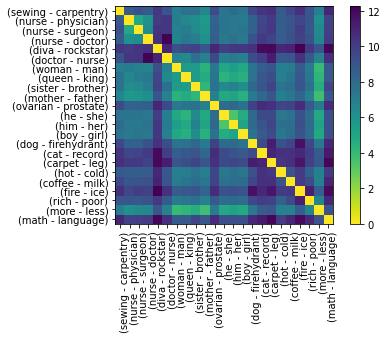

In [70]:
_ = make_debias_correlation_plot(pairs=[stereotype_pairs, appropriate_pairs, random_pairs], 
                                 language_model=BytePairLang("en", dim=300, vs=200_000), 
                                 metric="euclidean")

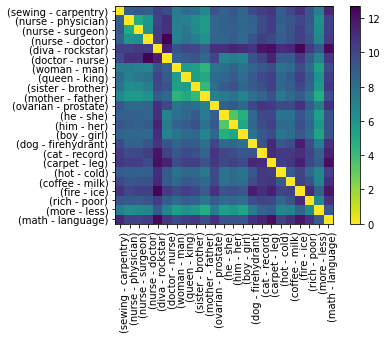

In [71]:
make_correlation_plot(pairs=[stereotype_pairs, appropriate_pairs, random_pairs], 
                      language_model=BytePairLang("en", dim=300, vs=200_000), 
                      metric="euclidean")

Looking at the euclidean distance, there's barely a change.